# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`
import pandas as pd
import numpy as np
import seaborn as sns
from netwulf import visualize

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

**ANSWER:** Reshuffle the network such that the degree sequence is preserved. Note the diameter of the network. Repeat this many times, say 1000 times. Count how often the diameter of the original network is larger than the diameter of the reshuffled network. If this is the case often (say more than 95 percent of the time), then the result of a large diameter is not random (it is statistically significant).

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

**ANSWER:**

1. The function swaps two edges in the graph while keeping the node degres fixed. This is done by removing two edges from the network --- call these u-v and x-y --- and creating the new edges u-x and v-y. If either u-x og v-y exists, another swap is attempted.
The function achieves randomness since random edges are chosen. It does not change the degree distribution, since one edge is removed from each of the four nodes and one edge is added to each of the four nodes, thus maintaining the degree of each node.

2. Not all swaps are possible, since the new edges might already exist (as mentioned above). Therefore, the number of swaps is limitied, meaning that `nswaps` is an upper bound.

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [2]:
# Load data
data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

# Choose only last year
t0 = data.timestamp.max() - 86400 * 7  # Lower bound of time-slice (here: 7 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice
data = data.loc[data.timestamp.between(t0, t1)]

# Create a graph from this dataframe
G = nx.from_pandas_edgelist(data, 'user1', 'user2')

ALCC: 0.018
Average ALCC: 0.009
p-value: 0.000


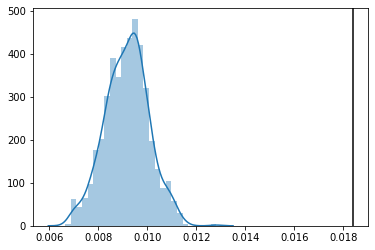

In [3]:
# 1: Print ALCC
ALCC = nx.average_clustering(G)
print("ALCC: {:.3f}".format(ALCC))

# 2: Generate 1000 nulls and store ALCC's
ALCCs = []
for i in range(1000):
    G_copy = G.copy()
    G_copy = nx.double_edge_swap(G_copy, nswap=1000, max_tries = 10000)
    ALCCs.append(nx.average_clustering(G_copy))
print('Average ALCC: {:.3f}'.format(np.mean(ALCCs)))

# 3: Print p-value
p = 0
for item in ALCCs:
    if item >= ALCC:
        p += 1/1000
print('p-value: {:.3f}'.format(p))
# ANSWER: The p-value is small, indicates that the null model rarely has an ALCC larger than the real data.
#         This indicates that the result is not random (it is significant)

# 4: Plot ALCC's
sns.distplot(ALCCs)
plt.axvline(ALCC, color='black')
# ANSWER: I see that all of the ALCC's based on the nulls are smaller than the one from the real data,
#         consistent with the ALCC of the real data being non-random.

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
 - **ANSWER:** $i,j \in \{1,2,\dots,N\}$ refers to each pair of nodes in the network.
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
 - **ANSWER:** $\delta(c_i,c_j)=1$ if the two nodes are in the same community and $\delta(c_i,c_j)=0$ otherwise. In other words, $\delta(\cdot,\cdot)$ is an indicator function for the nodes being in the same community. In this case, the function is used to ensure that we only sum over the nodes which belong to the same community. In code it can simply be implemented by checking if $c_i==c_j$ and then turning this boolean into an integer.
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
 - **ANSWER:** $k_i k_j$ is the product of the sum of the weights of the edges attached to $k_i$ and $k_j$. $2m$ is twice the sum of all the edge weights in the network. Thus, $\frac{k_ik_j}{2m}$ is a measure of the density of links between the two nodes. Specifically, it is the expected weight of the link between the two nodes, since each edge from each node can connect to $2m$ other nodes (or, actually $2m-1$). Thus, we are comparing to a null model with random edges (but with the same degree as the original network). Yes, we could have used other null models --- this is not neccesarily the only true comparison.
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
 - **ANSWER:** As explained in 2., we are only interested in nodes in the same community. The entire point is to compare the density of links inside a community to links between communities.
5. The sum term is normalized by $2m$. Why exactly $2m$?
 - **ANSWER:** As explained in 4., each edge from each node can connect to $2m$ other nodes (or, actually $2m-1$). Thus, we normalize by $2m$.
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.
 - **ANSWER:** The Louvain modularity function measures how densely packed the communities are. A larger value indicates more dense (closely linked) nodes inside the communities as compared to how closely linked communities are. Specfically, the number of links between each pair of nodes is compared to the actual number of links.

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [4]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    k = np.sum(A, axis = 0)  # Edge weights
    tm = np.sum(k)           # Twice the sum of all edge weights
    N = len(c)               # Number of nodes

    # Calculate sum
    sm = 0
    for i in range(N):
        for j in range(N):
            if c[i] == c[j]:
                sm += A[i,j] - k[i]*k[j]/tm

    # Return
    return sm/tm

# Calculate modularity
modularity(A,c)

0.12244897959183675

> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

In [5]:
# Create list of all possible partitions of nodes in communities (assuming 2 communities)
import itertools
pos_c = list(itertools.product([0,1], repeat=6))

# Store modularity of each of the partitions
mods = dict()
for c in pos_c:
    mods.update({c: modularity(A,c)})
    
# Get best partition
c_best = list(max(mods, key=mods.get))
print('Best c: {}'.format(c_best))
print('Corresponding modularity: {}'.format(modularity(A,c_best)))

Best c: [0, 0, 0, 1, 1, 1]
Corresponding modularity: 0.3571428571428571


#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [6]:
# Load data
data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

# Choose only last year
t0 = data.timestamp.max() - 86400 * 365  # Lower bound of time-slice (here: 7 days before last wall post)
t1 = data.timestamp.max()                # Upper bound of time-slice
data = data.loc[data.timestamp.between(t0, t1)]

# Create a graph from first 15000 observations in this dataframe
G = nx.from_pandas_edgelist(data[:15000], 'user1', 'user2')

Number of communities: 1235


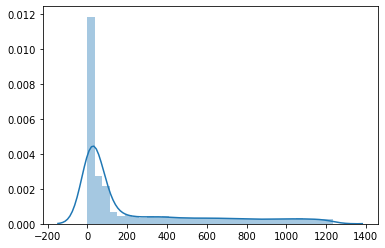

In [7]:
# Create partition in communities
partition = community.best_partition(G)
print('Number of communities: {}'.format(len(set(partition.values()))))
sns.distplot(list(partition.values()))

# COMMENT: Very many communities (~1200 communities for ~7000 nodes). With regards to the distribution of communities,
#          I see a very large tail

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

({'xlim': [0, 835],
  'ylim': [0, 835],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 1,
  'links': [{'source': 8938, 'target': 9248, 'width': 2, 'weight': 1},
   {'source': 9248, 'target': 3741, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 17754, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 10889, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 23246, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 28351, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 22502, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 4374, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 8768, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 11795, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 5423, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 25758, 'width': 2, 'weight': 1},
   {'source': 10891, 'target': 37256, 'width': 2, 'weight': 1},
   {'source': 10891, 'ta

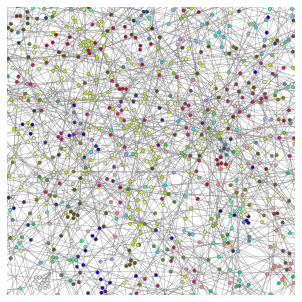

In [8]:
# Store communities for labelling
for k,v in G.nodes(data=True): v['group'] = partition[k]
    
# Visualize network
visualize(G)

# COMMENT: Looks like a hairball with very many communities. However, at least you can tell that some of
#          the communities make sense.

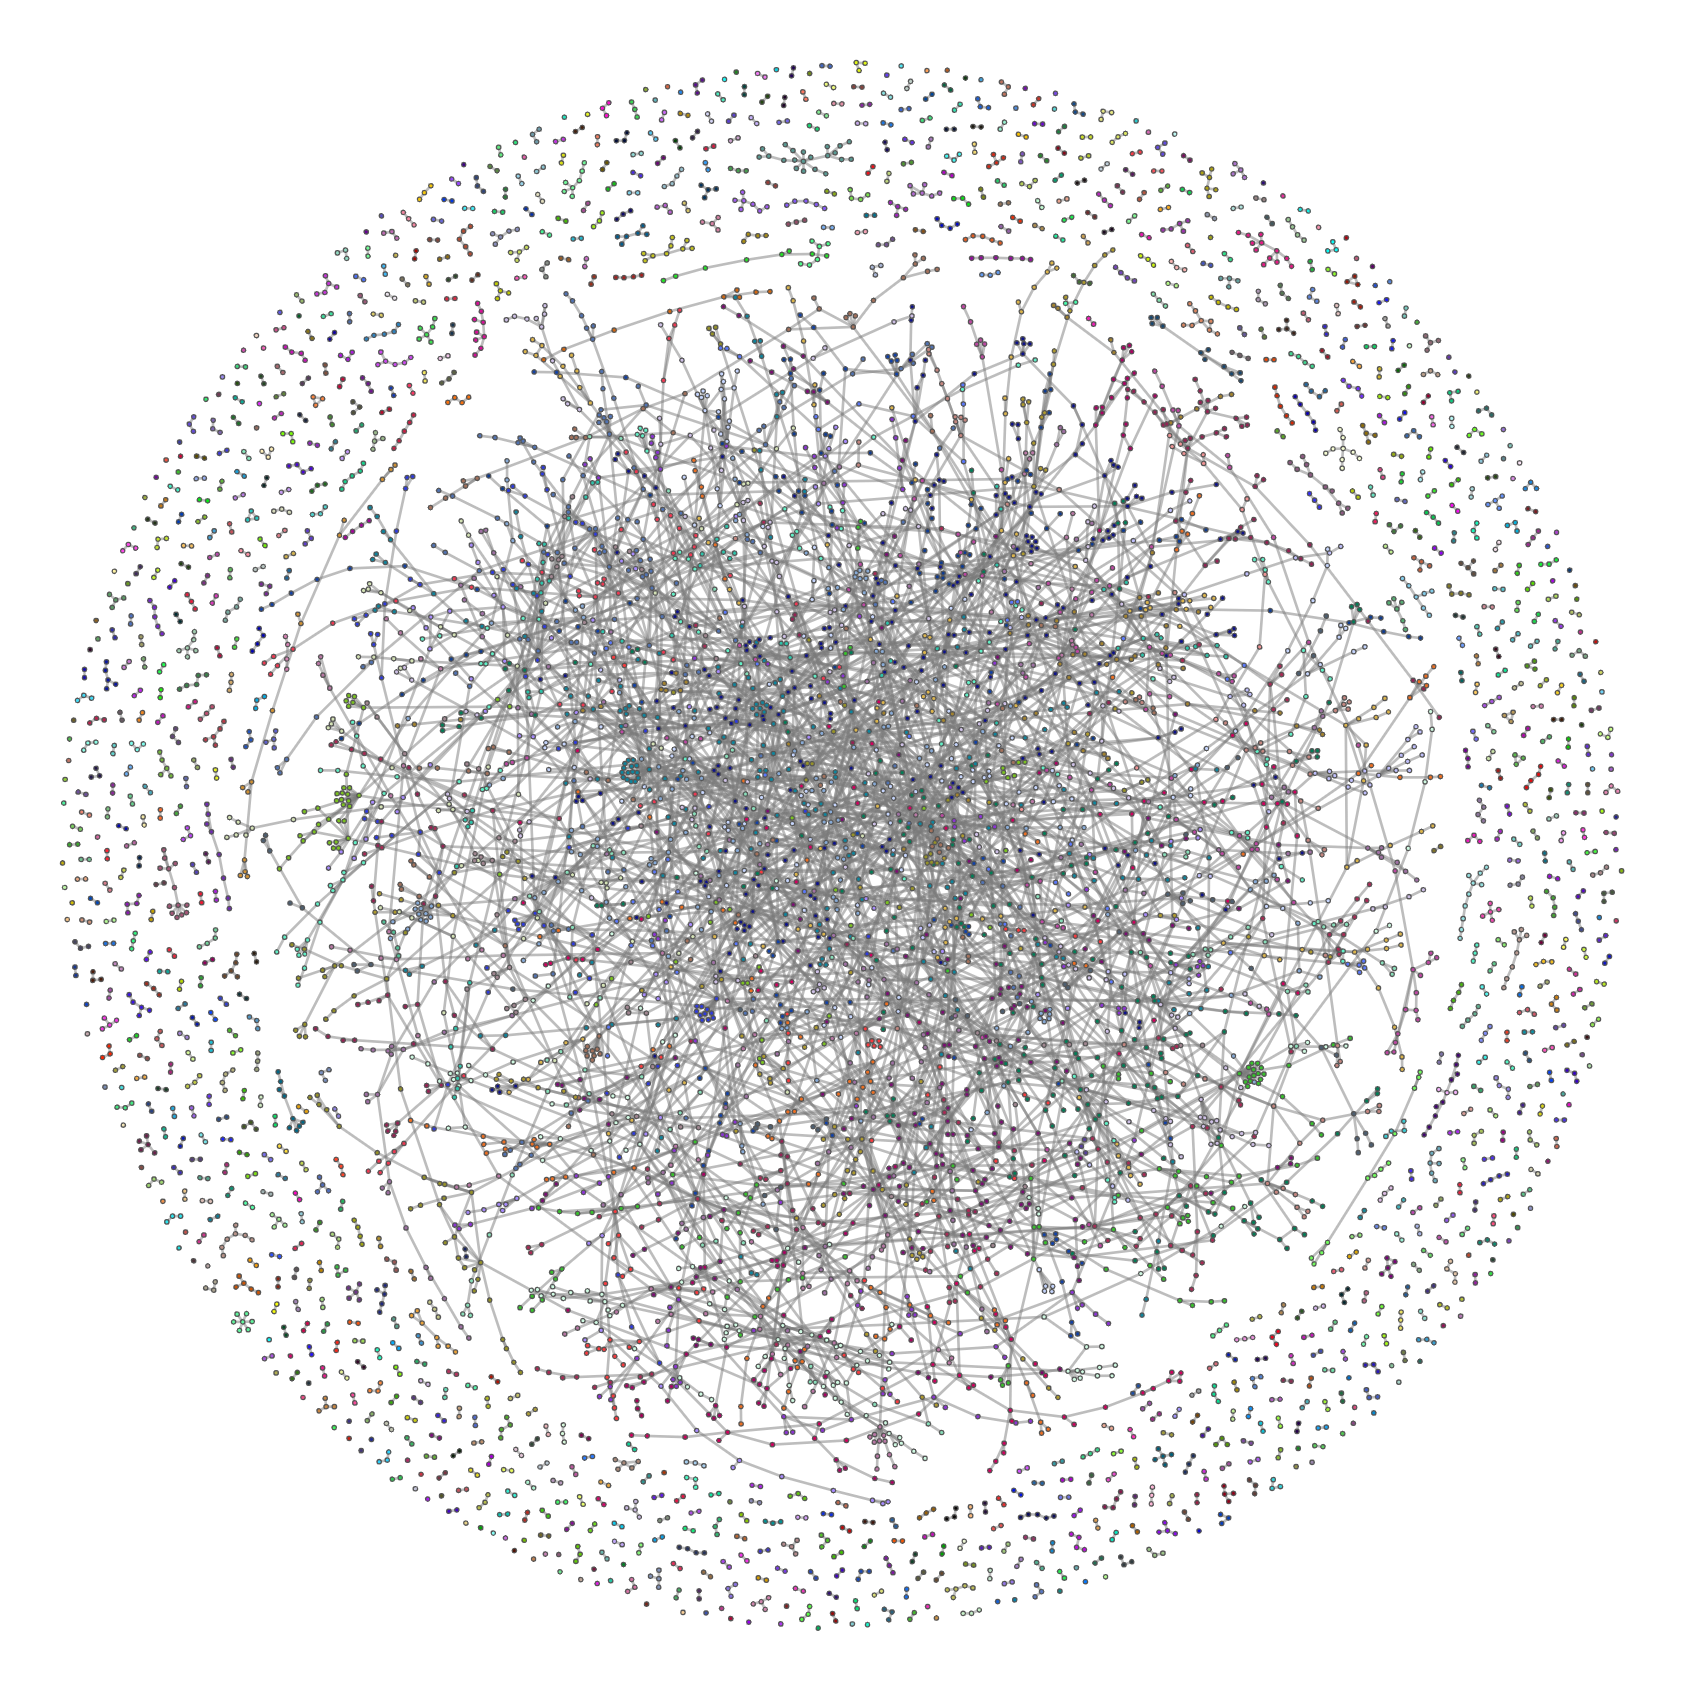

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

**ANSWER:** Implictely, the null model assumes that each node can be linked to any other node. This assumption gets more unreasonable the larger the network is, as each node is likely to only be connected to nodes from a small subset of the network. This also means that --- if the network is large enough --- the expected number of link between two communities is very small, such that just a single link between the two communities would lead the algorithm to conclude that the two communities are one.

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*